In [1]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict, concatenate_datasets, Value, Features
import re
import matplotlib.pyplot as plt
import json
from pathlib import Path

/NL/strategic-compute/work/svenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("Idavidrein/gpqa", "gpqa_extended")

In [3]:
writer = []
for item in ds["train"]:
    str1 = item["Writer's Difficulty Estimate"]
    diff = str1.split(" level ")[0] if str1 else None
    writer.append(diff)

In [4]:
# take all Non-Expert Validator Accuracy from train

non_exp = []
exp = []

for item in ds["train"]:
    str1 = item["Non-Expert Validator Accuracy"]
    str2 = item["Expert Validator Accuracy"]

    acc = float(str1) if str1 else 2
    non_exp.append(acc)

    acc2 = float(str2) if str2 else 2
    exp.append(acc2)

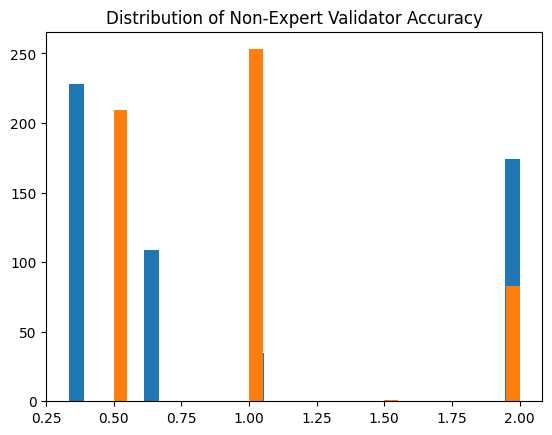

In [5]:
plt.hist(non_exp, bins=30)
plt.hist(exp, bins=30)
plt.title(f"Distribution of Non-Expert Validator Accuracy")
plt.show()

In [6]:
# take unique values

unique_writer = set(writer)
print("Unique Writer's Difficulty Estimates:")
for w in unique_writer:
    print(w)


Unique Writer's Difficulty Estimates:
None
Easy undergraduate
Post-graduate
Hard undergraduate
Hard graduate


In [7]:

mapping = {
    "Easy undergraduate": 1,
    "Hard undergraduate": 2,
    "Hard graduate": 3,
    "Post-graduate": 4,
}

In [8]:
import unicodedata
import re


def clean_text(s: str) -> str:
    s = unicodedata.normalize("NFKC", s)
    s = s.replace("\u2028", "").replace("\u2029", "").replace("\ufeff", "")
    s = re.sub(r"[\x00-\x1f\x7f]", "", s)
    return s

In [9]:
import random

INSTR = (
    "Answer the following multiple choice question. The last line of your response should be of the following format: "
    "'Answer: $LETTER' (without quotes) where LETTER is one of ABCD. Think step by step before answering.\n\n"
)


def gpqa_to_jsonl(gpqa_dd: DatasetDict, out_path: str, seed: int = 0):
    ds = gpqa_dd["train"]
    rng = random.Random(seed)

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    with out_path.open("w", encoding="utf-8") as f:
        for i, row in enumerate(ds):
            q = row["Question"]
            q = clean_text(q)
            correct = clean_text(row["Correct Answer"])
            incorrects = [
                clean_text(row["Incorrect Answer 1"]),
                clean_text(row["Incorrect Answer 2"]),
                clean_text(row["Incorrect Answer 3"]),
            ]

            writers_diff = row["Writer's Difficulty Estimate"]
            diff = writers_diff.split(" level ")[0] if writers_diff else None
            non_exp_acc = row["Non-Expert Validator Accuracy"]
            exp_acc = row["Expert Validator Accuracy"]

            options = [correct] + incorrects
            rng.shuffle(options)

            letters = ["A", "B", "C", "D"]
            correct_letter = letters[options.index(correct)]

            prompt = (
                INSTR
                + f"{q}\n\n"
                + f"A) {options[0]}\n"
                + f"B) {options[1]}\n"
                + f"C) {options[2]}\n"
                + f"D) {options[3]}"
            )

            obj = {
                "id": f"gpqa-{i+1}",
                "question": prompt,
                "final": correct_letter,
                "writer_difficulty": mapping.get(diff, None),
                "non_expert_validator_accuracy": (
                    float(non_exp_acc) if non_exp_acc else None
                ),
                "expert_validator_accuracy": float(exp_acc) if exp_acc else None,
            }

            # if obj["writer_difficulty"] == 4:
            f.write(json.dumps(obj, ensure_ascii=False) + "\n")

In [10]:
gpqa_to_jsonl(ds, "../datasets/GPQA/test_diff.jsonl", seed=1234)

In [17]:
mapping = {
    "Easy undergraduate": 1,
    "Hard undergraduate": 2,
    "Hard graduate": 3,
    "Post-graduate": 4,
}

In [ ]:
import random

INSTR = (
    "Answer the following multiple choice question. The last line of your response should be of the following format: "
    "'Answer: $LETTER' (without quotes) where LETTER is one of ABCD. Think step by step before answering.\n\n"
)

objs = []


def transf_ds(gpqa_dd: DatasetDict, seed: int = 0):
    ds = gpqa_dd["train"]
    rng = random.Random(seed)

    for i, row in enumerate(ds):
        q = row["Question"]
        q = clean_text(q)
        correct = clean_text(row["Correct Answer"])
        incorrects = [
            clean_text(row["Incorrect Answer 1"]),
            clean_text(row["Incorrect Answer 2"]),
            clean_text(row["Incorrect Answer 3"]),
        ]

        options = [correct] + incorrects
        rng.shuffle(options)

        letters = ["A", "B", "C", "D"]
        correct_letter = letters[options.index(correct)]

        prompt = (
            INSTR
            + f"{q}\n\n"
            + f"A) {options[0]}\n"
            + f"B) {options[1]}\n"
            + f"C) {options[2]}\n"
            + f"D) {options[3]}"
        )

        obj = {
            "id": f"gpqa-{i+1}",
            "question": prompt,
            "final": correct_letter,
        }

        objs.append(obj)

    return objs

In [5]:
import json
from datasets import load_dataset


def create_diamond_diff_file(
    input_path="test_diff.jsonl", 
    output_path="test_diff_diamond.jsonl"
):
    print("Loading GPQA Diamond dataset...")
    # 1. Load the Diamond dataset
    ds = load_dataset("Idavidrein/gpqa", "gpqa_diamond", split="train")
    
    # 2. Extract raw diamond questions
    # We strip whitespace just to be safe, but keep the full text
    diamond_questions = [q.strip() for q in ds["Question"]]
    
    print(f"Loaded {len(diamond_questions)} diamond questions.")
    
    matched_count = 0
    
    # 3. Filter the file
    with open(input_path, "r") as f_in, open(output_path, "w") as f_out:
        for line in f_in:
            data = json.loads(line)
            long_text = data["question"]  # This has the system prompt + question
            
            # Check if this long text contains ANY of the diamond questions
            # (i.e., is the diamond question a substring of the long prompt?)
            is_match = False
            for dq in diamond_questions:
                if dq in long_text:
                    is_match = True
                    break
            
            if is_match:
                f_out.write(line)
                matched_count += 1

    print(f"Filtered file created at {output_path}")
    print(f"Total lines matched and saved: {matched_count}")


create_diamond_diff_file("../datasets/GPQA/test_diff.jsonl", "../datasets/GPQA/test_diff_diamond.jsonl")

Loading GPQA Diamond dataset...
Loaded 198 diamond questions.
Filtered file created at ../datasets/GPQA/test_diff_diamond.jsonl
Total lines matched and saved: 198
